<a href="https://colab.research.google.com/github/visualcomments/tiktok_studies/blob/main/tiktok_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По тегам, которые болше всего похожи на запросы "python", "программирование" и "анализ данных", попробуем понять, какие ролики важные в этой области.

Почему нам важны теги? В тиктоке они влияют на попадание роликов в рекомендации. https://vc.ru/social/90271-stoit-li-rabotat-s-blogerami-v-tik-tok-za-i-protiv

На предыдущем шаге мы получили максимально похожие на запрос теги. Теперь возьмем список из топ-20 этих тегов, вытащим из них информацию об каналах и проверим, какие из них является важными.

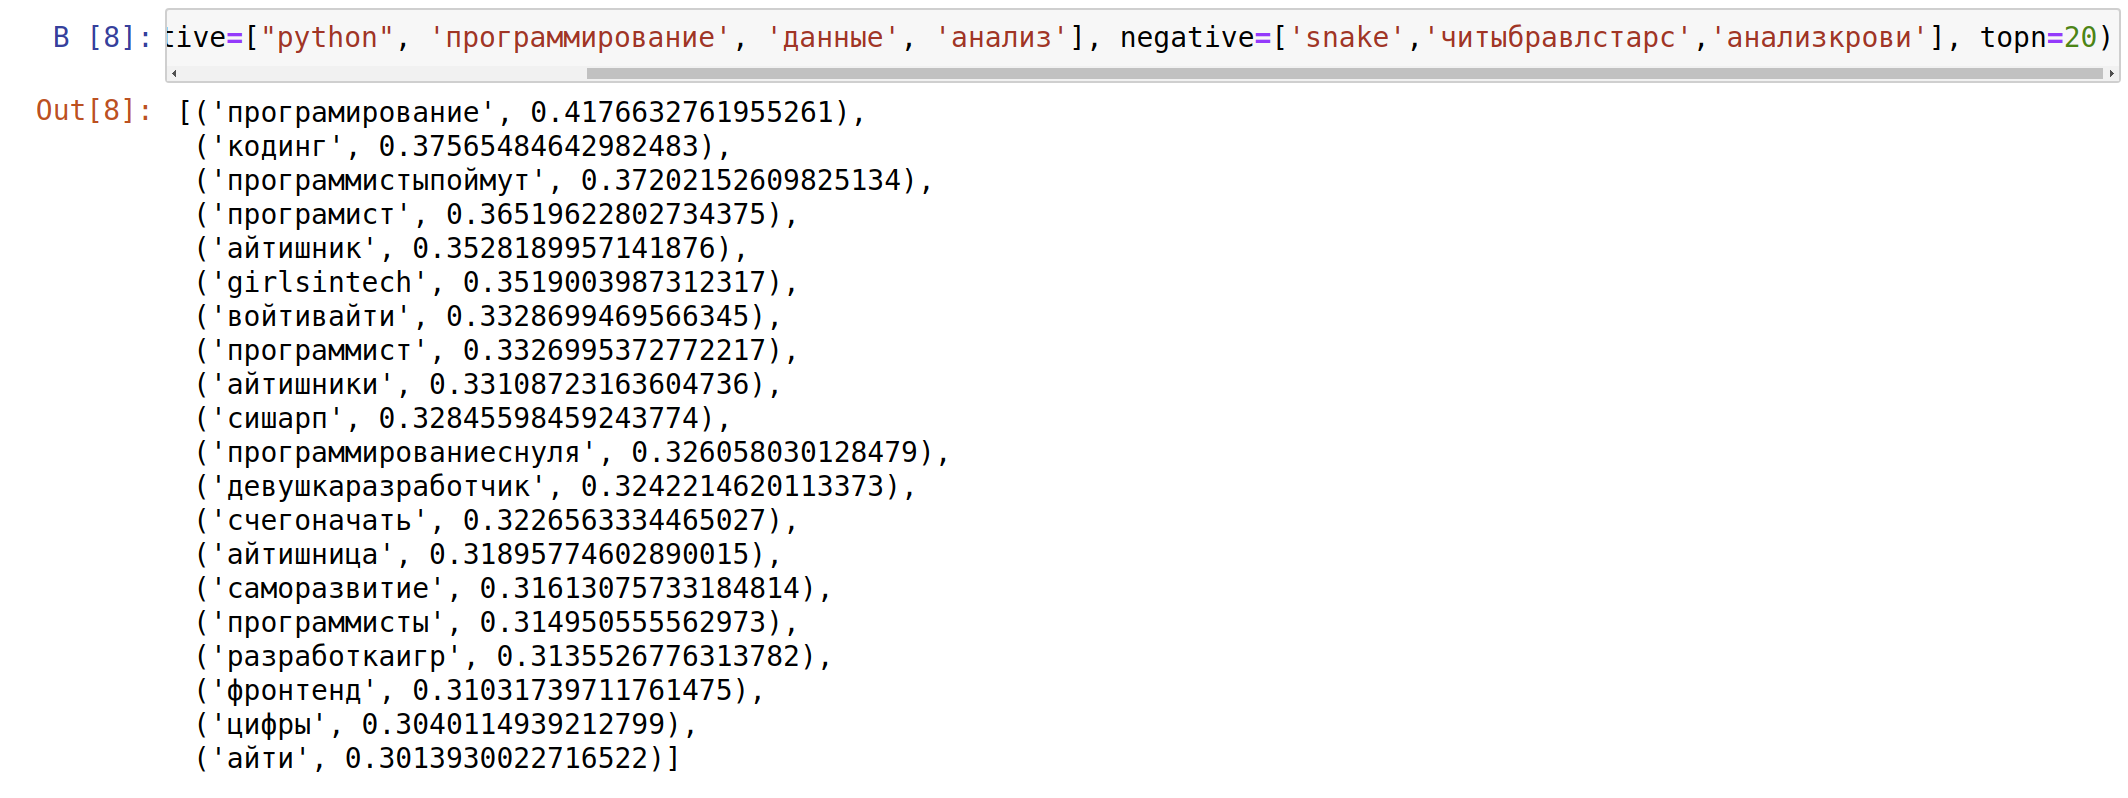

Ссылка на датафрейм: https://drive.google.com/file/d/1VZgZkao9pkbyvc7RUlok3njFXQ2hN2EY/view?usp=sharing

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving dtf.csv to dtf (1).csv


In [ ]:
import pandas as pd
import io

In [ ]:
dtf = pd.read_csv(io.StringIO(uploaded['dtf.csv'].decode('utf-8')))

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100

In [ ]:
dtf.shape

(17075, 44)

Мы можем выделить из метаданных роликов коэффициент вирусности по таким показателям, как "лайки", "комментарии", "поделиться". Коэффициент будет высчитываться по формуле: *коэффициент = вирусное действие / просмотры*.

(Отсюда: https://www.talkwalker.com/blog/how-to-measure-virality)

Возьмем статистически значимые ролики с показателями больше 1000.

In [ ]:
dtf = dtf.loc[dtf['shareCount'] >= 1000]

dtf['virality_share'] = dtf['shareCount']/dtf['playCount']

dtf = dtf.loc[dtf['diggCount'] >= 1000]

dtf['virality_like'] = dtf['diggCount']/dtf['playCount']

dtf = dtf.loc[dtf['commentCount'] >= 1000]

dtf['virality_comment'] = dtf['commentCount']/dtf['playCount']

In [ ]:
dtf.shape

(112, 47)

Теперь подготовим датафрейм для создания двудольного графа, где вершины из 1-й доли - это айди каналов, а вершины из 2-й доли - это теги, которые используют каналы.

In [ ]:
import re

dtf["hashtags"] = dtf["hashtags"].str.replace(r"[^a-zA-Zа-яА-Я]+", " ").str.strip()

In [ ]:
dtf["hashtags"] = dtf["hashtags"].str.replace('ё','е')

In [ ]:
import nltk
nltk.download('wordnet')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


dtf['hashtags_lemmatized'] = dtf.hashtags.apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
dtf_new = dtf.explode('hashtags_lemmatized')

In [ ]:
dtf_new.shape

(5690, 48)

Убираем слова, общие для всех строк.

In [ ]:
dtf_new = dtf_new[(dtf_new.hashtags_lemmatized != 'id') & (dtf_new.hashtags_lemmatized != 'name')
               & (dtf_new.hashtags_lemmatized != 'title') & (dtf_new.hashtags_lemmatized != 'cover')]

In [ ]:
df_for_g = pd.DataFrame(dtf_new, columns=['authorMeta.id', 'hashtags_lemmatized'])

In [ ]:
df_for_g.rename(columns={'authorMeta.id': 'source', 'hashtags_lemmatized': 'target'}, inplace = True)

In [ ]:
df_for_g.shape

(2433, 2)

In [ ]:
df_for_g['source'] = df_for_g['source'].astype('str')
df_for_g['target'] = df_for_g['target'].astype('str')

In [ ]:
import networkx as nx
import community
import collections
from networkx.algorithms import bipartite
import pylab as pl
import matplotlib.pyplot as plt

Добавляем веса для ребер графа.

In [ ]:
df_try = df_for_g.dropna(subset=['target'])

In [ ]:
df_try.isnull().sum()

source    0
target    0
dtype: int64

In [ ]:
df_final = df_try.groupby(['source','target']).size().reset_index().rename(columns={0:'weight'})

In [ ]:
df_final.isna().sum()

source    0
target    0
weight    0
dtype: int64

In [ ]:
df_final.shape

(1729, 3)

In [ ]:
G_all = nx.Graph()
G_all.add_nodes_from(df_final['source'], bipartite=0)
G_all.add_nodes_from(df_final['target'], bipartite=1)
edges = df_final[['source', 'target','weight']].apply(tuple, axis=1)
G_all.add_weighted_edges_from(edges)

In [ ]:
nx.is_bipartite(G_all)

True

Граф у нас есть, но чтобы считать по нему меры центральности, надо преобразовать его из двудольного в простой.

In [ ]:
G_sub = G_all.subgraph(nx.shortest_path(G_all.to_undirected(),'программирование'))

In [ ]:
len(G_sub.nodes)

985

In [ ]:
entity_nodes, individual_nodes = bipartite.sets(G_sub)

In [ ]:
entity_nodes = set(n for n,d in G_sub.nodes(data=True) if d['bipartite']==1)

In [ ]:
individual_nodes = set(G_sub) - entity_nodes

In [ ]:
G = bipartite.weighted_projected_graph(G_sub, individual_nodes)

In [ ]:
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 85
Number of edges: 1556
Average degree:  36.6118


Определяем пейджранк для каждой вершины и конкатенируем с датафреймом.

In [ ]:
def pr_summary(G):
    pr = nx.pagerank(G)
    df = pd.DataFrame.from_dict({
        'authorMeta.id': list(pr.keys()),
        'centrality_pr': list(pr.values())
    })
    return df.sort_values('centrality_pr', ascending=False)

In [ ]:
pr = pd.DataFrame(pr_summary(G), columns=['authorMeta.id', 'centrality_pr'])

In [ ]:
pr.reset_index(drop=True, inplace=True)
dtf.reset_index(drop=True, inplace=True)

In [ ]:
df_concat = pd.concat([pr, dtf], axis = 1)

In [ ]:
df_concat.sort_values(by = 'centrality_pr', ascending = False).head(10)

,authorMeta.id,centrality_pr,Unnamed: 0,id,secretID,text,createTime,authorMeta.id,authorMeta.secUid,authorMeta.name,authorMeta.nickName,authorMeta.verified,authorMeta.signature,authorMeta.avatar,authorMeta.following,authorMeta.fans,authorMeta.heart,authorMeta.video,authorMeta.digg,musicMeta.musicId,musicMeta.musicName,musicMeta.musicAuthor,musicMeta.musicOriginal,musicMeta.musicAlbum,musicMeta.playUrl,musicMeta.coverThumb,musicMeta.coverMedium,musicMeta.coverLarge,musicMeta.duration,covers.default,covers.origin,covers.dynamic,webVideoUrl,videoUrl,videoUrlNoWaterMark,videoApiUrlNoWaterMark,videoMeta.height,videoMeta.width,videoMeta.duration,diggCount,shareCount,playCount,commentCount,downloaded,mentions,hashtags,virality_share,virality_like,virality_comment,hashtags_lemmatized
0,6786858749715497990,0.030150,1,6905319150680280321,6905319150680280321,"Поймут только технари#айти , #IT, #айтишник, #сисадмин, #программист, #технарь, #технари, #пк, #...",1607769904,6858525935664219142,MS4wLjABAAAADVYJiZXXqyTBfkCGfiRK-o3N3_9JkyyBJTEO310FYnTwVP5EWGy7waeDPwNXtx_V,evgabelkina,Евгения Белкина,False,Инсты нет,https://p58-sign-sg.tiktokcdn.com/aweme/1080x1080/tos-alisg-avt-0068/bde58651f6727c06e3e08d7125a...,6021,9750,526100,418,139,6.742946e+18,original sound,Mark,True,NaN,https://sf58-sg.tiktokcdn.com/obj/musically-maliva-obj/1646227971455030.mp3,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1635095562142726~c5_100x100.jpeg?x-expire...,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1635095562142726~c5_720x720.jpeg?x-expire...,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1635095562142726~c5_1080x1080.jpeg?x-expi...,12.0,https://p58-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/3122c729251d4e148ed0a83a41253348?x-expire...,https://p58-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/87b4bb12f1234160b962ceb5d5023ea6_16077699...,https://p58-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/a4ef615f7602474bb71de97149e92348_16077699...,https://www.tiktok.com/@evgabelkina/video/6905319150680280321,https://v16-web.tiktok.com/video/tos/alisg/tos-alisg-pve-0037c001/20596caa57a04331aed97a5506403e...,NaN,NaN,960,544,12,94900,1660,547900,1039,False,[],id name айти title cover id name it title cover id name айтишник title cover id name сисадмин ti...,0.003030,0.173207,0.001896,"[id, name, айти, title, cover, id, name, it, title, cover, id, name, айтишник, title, cover, id,..."
1,6705498522727040005,0.026903,0,6900078992204893441,6900078992204893441,#Притча про орла. #возрождение #жизненно #саморазвитие Озвучка - @saymyr_voice,1606549835,6769534596881253382,MS4wLjABAAAAoZ2p5zk686x5kKYTiR4tgVSLoYhDM7uGlCuG71Gb31HiJ7m3EXoNBnMIJblKheC5,actmotivator,Действуй! Мотивация,False,‼️Действуй! Иначе сегодня опять ничего не изменится.‼️\nИнформация тут⬇️,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1658006392712197~c5_1080x1080.jpeg?x-expi...,8,304400,3300000,122,1157,6.900079e+18,оригинальный звук,Действуй! Мотивация,True,NaN,https://sf58-sg.tiktokcdn.com/obj/tiktok-obj/6900078943043586817.mp3,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1658006392712197~c5_100x100.jpeg?x-expire...,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1658006392712197~c5_720x720.jpeg?x-expire...,https://p16-sign-sg.tiktokcdn.com/musically-maliva-obj/1658006392712197~c5_1080x1080.jpeg?x-expi...,57.0,https://p58-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/89c128f91e4f40738fa49f269b932fe6?x-expire...,https://p58-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/adec97e7306e4fad825dc1dcab7d9a0e_16065498...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alisg-p-0037/96fe3649b67a46378351ce559b17cbb6_16065498...,https://www.tiktok.com/@actmotivator/video/6900078992204893441,https://v16-web.tiktok.com/video/tos/alisg/tos-alisg-pve-0037c001/da954daaf6144446b63ae8138292c3...,NaN,NaN,1024,576,57,563300,29500,3700000,2025,False,"[""@saymyr_voice""]",id name притча title cover id name возрождение title cover id name жизненно title А ты сталкивал...,0.007973,0.152243,0.000547,

Из топ-10 пейджранка есть только один (первый) ролик со ссылкой на айти-тематику, остальные связаны с темами личностного роста, психологии, рекламы и так далее. Судя по этому, в выборке важнен тег "саморазвитие".